Notebook to compute the total cases predicted for each validation test. 

Each validation test represents a season with 52 weeks. For each of these weeks, the parameters of a log-normal distribution obtained from the log_normal_parameters.ipynb notebook are used to generate 1,000 samples. The samples for each week are summed, and from this total, the 50%, 80%, 90%, and 95% prediction intervals, as well as the median of the total cases in the season, are calculated.

Using these estimates, we calculate the WIS for each model in comparison with the observed values:

In [1]:
import numpy as np
import pandas as pd 
from epiweeks import Week
from numpy import log, exp
from itertools import product 
import matplotlib.pyplot as plt 
from scipy.stats import lognorm

import matplotlib as mpl

# Definir a cor das bordas (spines) como cinza
mpl.rcParams['axes.edgecolor'] = 'gray'

# Definir a cor das linhas dos ticks maiores e menores como cinza
mpl.rcParams['xtick.color'] = 'gray'
mpl.rcParams['ytick.color'] = 'gray'
mpl.rcParams['xtick.labelcolor'] = 'black'
mpl.rcParams['ytick.labelcolor'] = 'black'
plt.rcParams['axes.labelsize'] = 16 # Axis labels
plt.rcParams['xtick.labelsize'] = 14  # X-axis tick labels
plt.rcParams['ytick.labelsize'] = 14  # Y-axis tick labels
plt.rcParams['font.size'] = 16  # General font size
FONT = 12


Load the data: 

In [2]:
data = pd.read_csv('/Users/eduardoaraujo/Documents/sprint_data_2025/dengue.csv.gz')
data.date = pd.to_datetime(data.date)
data = data.groupby(['date', 'uf'])[['casos']].sum().reset_index()
data = data.sort_values(by = 'date')

data['valid_test'] = None

data.loc[(data.date >= Week(2022, 41).startdate().strftime('%Y-%m-%d')) & (data.date <= Week(2023, 40).startdate().strftime('%Y-%m-%d')), 'valid_test'] = '1'  

data.loc[(data.date >= Week(2023, 41).startdate().strftime('%Y-%m-%d')) & (data.date <= Week(2024, 40).startdate().strftime('%Y-%m-%d')), 'valid_test'] = '2'

data.loc[(data.date >= Week(2024, 41).startdate().strftime('%Y-%m-%d')) & (data.date <= Week(2025, 40).startdate().strftime('%Y-%m-%d')), 'valid_test'] = '3' 


data.head()

,date,uf,casos,valid_test
0,2010-01-03,AC,760,None
26,2010-01-03,TO,231,None
25,2010-01-03,SP,1628,None
24,2010-01-03,SE,3,None
23,2010-01-03,SC,10,None


In [10]:
df_agg = data.dropna().groupby(['uf', 'valid_test'])[['casos']].sum().reset_index().rename(columns = {'uf': 'state'})
df_agg['valid_test'] = df_agg['valid_test'].astype(int)
df_agg.head()

,state,valid_test,casos
0,AC,1,4735
1,AC,2,9741
2,AC,3,12275
3,AL,1,4779
4,AL,2,18667


In [4]:
data_23 = data.loc[(data.date >= Week(2022, 41).startdate().strftime('%Y-%m-%d')) & (data.date <= Week(2023, 40).startdate().strftime('%Y-%m-%d'))] 
data_24 = data.loc[(data.date >= Week(2023, 41).startdate().strftime('%Y-%m-%d')) & (data.date <= Week(2024, 40).startdate().strftime('%Y-%m-%d'))] 
data_25 = data.loc[(data.date >= Week(2024, 41).startdate().strftime('%Y-%m-%d')) & (data.date <= Week(2025, 40).startdate().strftime('%Y-%m-%d'))] 


Load the predictions with log normal parameters estimated:

In [5]:
df_preds =  pd.read_csv('predictions/preds_CDF.csv')

df_preds = df_preds.loc[df_preds.state != 'ES']

df_preds.loc[df_preds.mu.isna(), ['mu', 'sigma']] = [0.01, 1/2]

df_preds.head()

,date,lower_95,lower_90,lower_80,lower_50,pred,upper_50,upper_80,upper_90,upper_95,valid_test,state,model_id,mu,sigma
0,2024-10-06,22.422222,40.304679,79.162970,244.274988,853.700012,2982.915845,9196.810733,18041.732884,32366.797486,3,RS,108,6.748348,1.855412
1,2024-10-13,18.743651,34.187301,68.269130,216.515891,779.997873,2809.263104,8900.886361,17748.532118,32294.740637,3,RS,108,6.657830,1.900458
2,2024-10-20,6.581569,12.226861,24.874887,81.165077,301.351891,1118.132411,3638.484729,7371.869282,13600.483733,3,RS,108,5.704178,1.945792
3,2024-10-27,17.097895,32.060474,66.082749,220.934380,843.905436,3222.679992,10763.205908,22149.610067,41420.387215,3,RS,108,6.736465,1.987314
4,2024-11-03,18.724941,35.572182,74.438413,255.270334,1003.039414,3940.407380,13500.169745,28209.239339,53454.977878,3,RS,108,6.909363,2.029238


Get cumulative cases: 

In [7]:
cum_cases = []

for state, valid_test, model in product(df_preds.state.unique(), df_preds.valid_test.unique(), df_preds.model_id.unique()): 

    df_model = df_preds.loc[(df_preds.model_id == model) & (df_preds.state ==state) & (df_preds.valid_test == valid_test)]

    samples = np.zeros(1000)

    for mu, sigma in zip(df_model.mu, df_model.sigma):
    
        samples = samples + lognorm.rvs(s=sigma, scale=np.exp(mu), size=1000)

    cum_cases.append(pd.DataFrame([[model,state, valid_test] + list(np.percentile(samples, [2.5, 5, 10, 25, 50, 75, 90, 95, 97.5]))], 
                                  
                                  columns = ['model_id', 'state', 'valid_test',
                                             'lower_95', 'lower_90', 'lower_80', 'lower_50', 'pred', 
                                             'upper_50', 'upper_80', 'upper_90', 'upper_95'])
                    )
df_cum_cases = pd.concat(cum_cases, ignore_index = True)

df_cum_cases.head()

,model_id,state,valid_test,lower_95,lower_90,lower_80,lower_50,pred,upper_50,upper_80,upper_90,upper_95
0,108,RS,3,3.587993e+06,4.437816e+06,6.212480e+06,9.902456e+06,1.811139e+07,4.176463e+07,1.029506e+08,1.755838e+08,3.132201e+08
1,133,RS,3,3.347567e+05,3.573175e+05,3.804145e+05,4.257628e+05,4.805270e+05,5.505005e+05,6.312161e+05,6.919411e+05,7.357093e+05
2,134,RS,3,5.337534e+05,5.470363e+05,5.712743e+05,6.119451e+05,6.662994e+05,7.410743e+05,8.288667e+05,8.894661e+05,9.373726e+05
3,135,RS,3,2.497842e+04,2.542642e+04,2.632379e+04,2.805932e+04,3.014639e+04,3.226802e+04,3.449388e+04,3.579211e+04,3.678028e+04
4,136,RS,3,1.270966e+04,1.395121e+04,1.617627e+04,2.053734e+04,2.762188e+04,3.754131e+04,5.300411e+04,6.591558e+04,7.996254e+04


In [12]:
df_cum_cases_agg = df_cum_cases.merge(df_agg, on = ['state', 'valid_test'])

df_cum_cases_agg.head()

,model_id,state,valid_test,lower_95,lower_90,lower_80,lower_50,pred,upper_50,upper_80,upper_90,upper_95,casos
0,108,RS,3,3.587993e+06,4.437816e+06,6.212480e+06,9.902456e+06,1.811139e+07,4.176463e+07,1.029506e+08,1.755838e+08,3.132201e+08,88884
1,133,RS,3,3.347567e+05,3.573175e+05,3.804145e+05,4.257628e+05,4.805270e+05,5.505005e+05,6.312161e+05,6.919411e+05,7.357093e+05,88884
2,134,RS,3,5.337534e+05,5.470363e+05,5.712743e+05,6.119451e+05,6.662994e+05,7.410743e+05,8.288667e+05,8.894661e+05,9.373726e+05,88884
3,135,RS,3,2.497842e+04,2.542642e+04,2.632379e+04,2.805932e+04,3.014639e+04,3.226802e+04,3.449388e+04,3.579211e+04,3.678028e+04,88884
4,136,RS,3,1.270966e+04,1.395121e+04,1.617627e+04,2.053734e+04,2.762188e+04,3.754131e+04,5.300411e+04,6.591558e+04,7.996254e+04,88884


In [22]:
def make_plot(ax, df_cum_cases, state, valid_test): 
    '''
    make the figure with the error bars 
    '''
    df_cum = df_cum_cases.loc[(df_cum_cases.state == state) & (df_cum_cases.valid_test == valid_test)]

    obs = df_cum.casos.values[0]

    ax.axhline(obs, color = 'black', linewidth =2, linestyle = '--', label = 'Data')
    
    x = df_cum.model_id.astype(str)
    y = df_cum.pred
    
    # compute symmetric errors from lower and upper bounds
    yerr = np.array([y - df_cum.lower_95, df_cum.upper_95 - y])

    for xi, yi, yierr, low, up in zip(x, y, yerr.T, df_cum.lower_95, df_cum.upper_95):
    # condition: observed is inside prediction interval
        if low <= obs <= up:
            ecolor = "tab:green"
        else:
            ecolor = "tab:red"
        
        ax.errorbar(xi, yi, yerr=yierr.reshape(2,1), fmt="o", 
                    color=ecolor, ecolor=ecolor, capsize=5)
        
    # scatter plot with vertical error bars
    #ax.errorbar(x, y, yerr=yerr, fmt='o', color='tab:blue', ecolor='tab:blue', capsize=5)

    #df_cum_in = df_cum.loc[(df_cum.upper_95 >= df_cum.casos) & (df_cum.lower_95 <= df_cum.casos)]

    #df_cum_out = df_cum.loc[(df_cum.upper_95 >= df_cum.casos) & (df_cum.lower_95 <= df_cum.casos)]

        
    #ax.set_ylim([0, 5*10**5])
    
    ax.set_ylabel('Cumulative cases')
    ax.set_xlabel('Model ID')
    
    ax.set_title(f'Validation test - {valid_test} - {state}')

    ax.set_ylim([0, max(2*df_cum_cases.loc[(df_cum_cases.state == state) & (df_cum_cases.valid_test == 1)].casos.values[0],
                        2*df_cum_cases.loc[(df_cum_cases.state == state) & (df_cum_cases.valid_test == 2)].casos.values[0], 
                        2*df_cum_cases.loc[(df_cum_cases.state == state) & (df_cum_cases.valid_test == 3)].casos.values[0])])
    ax.grid()
    ax.legend()
    for label in ax.get_xticklabels():
        label.set_rotation(90)


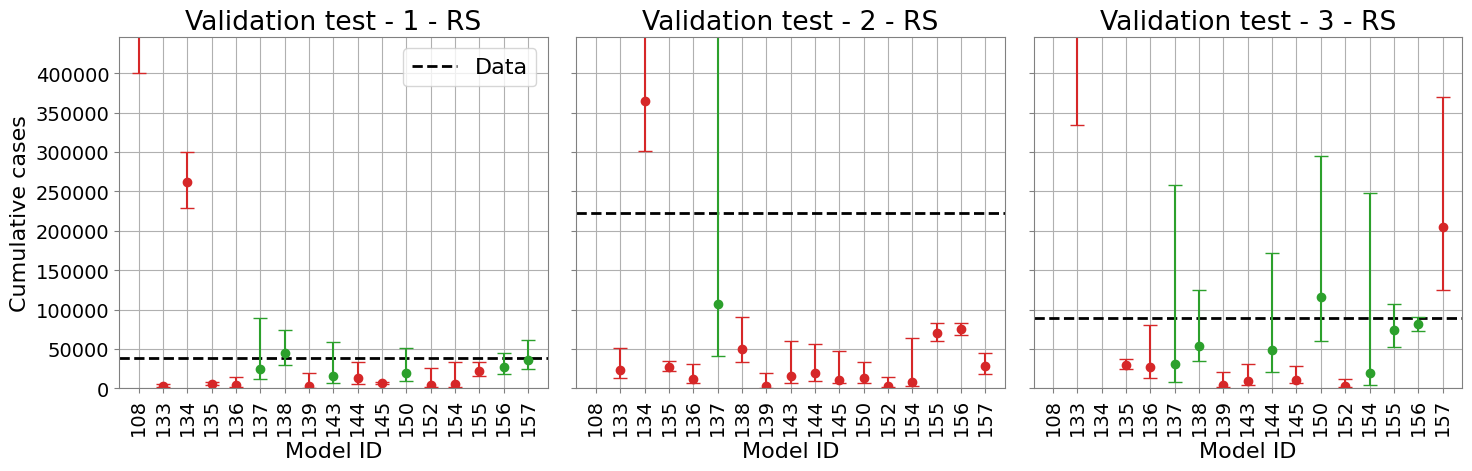

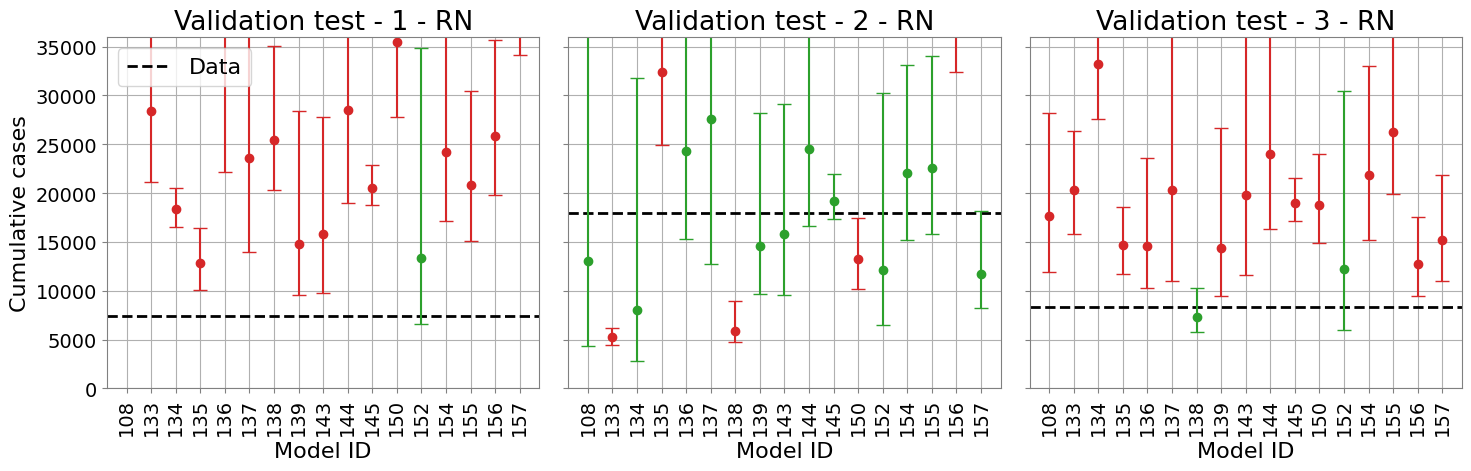

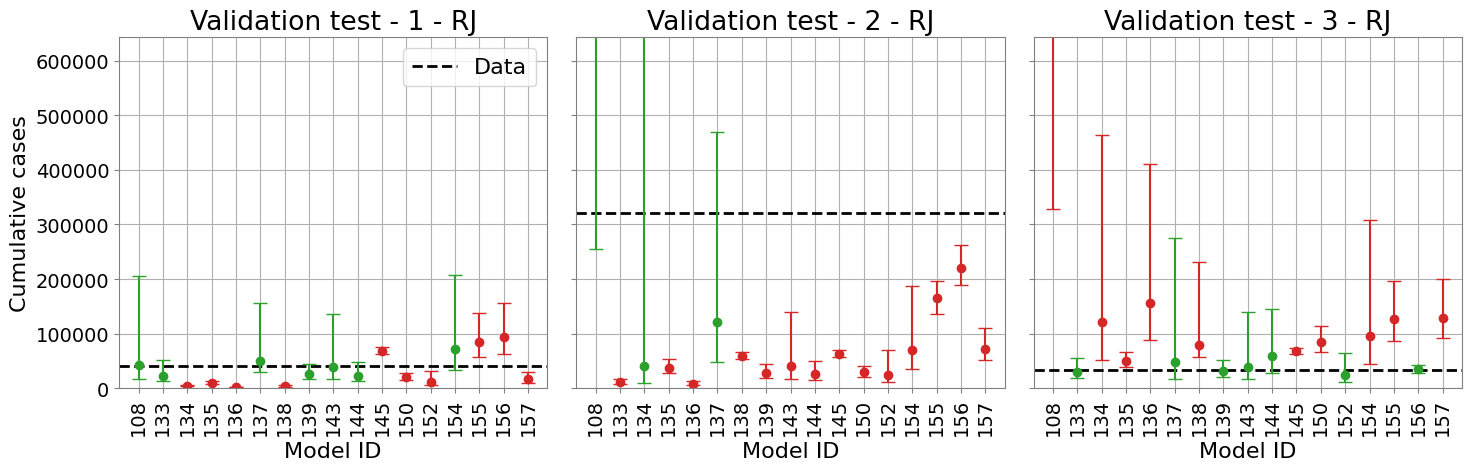

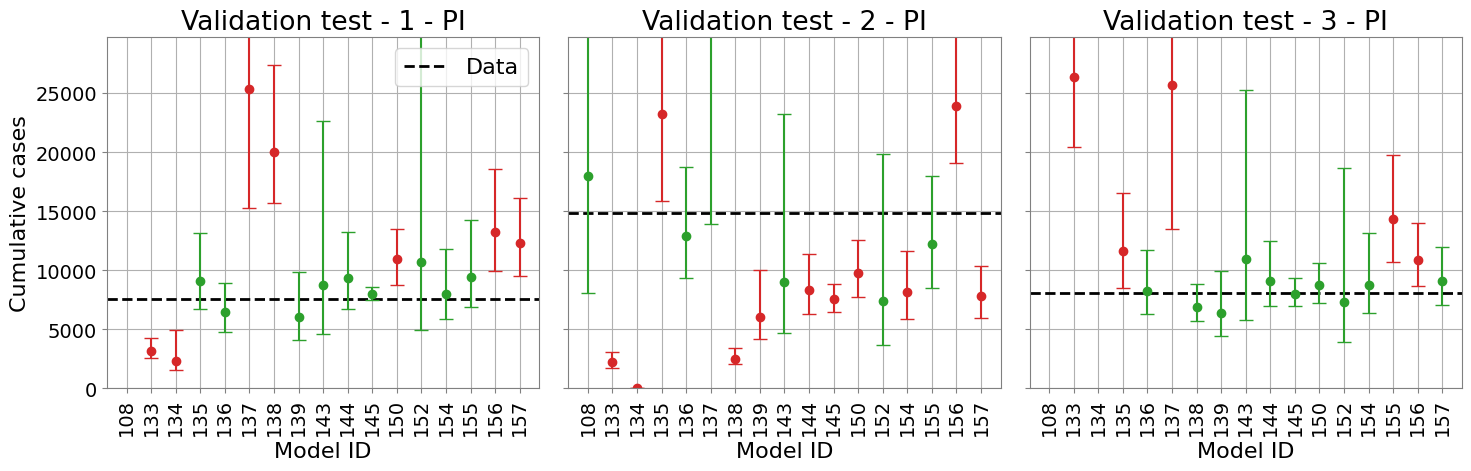

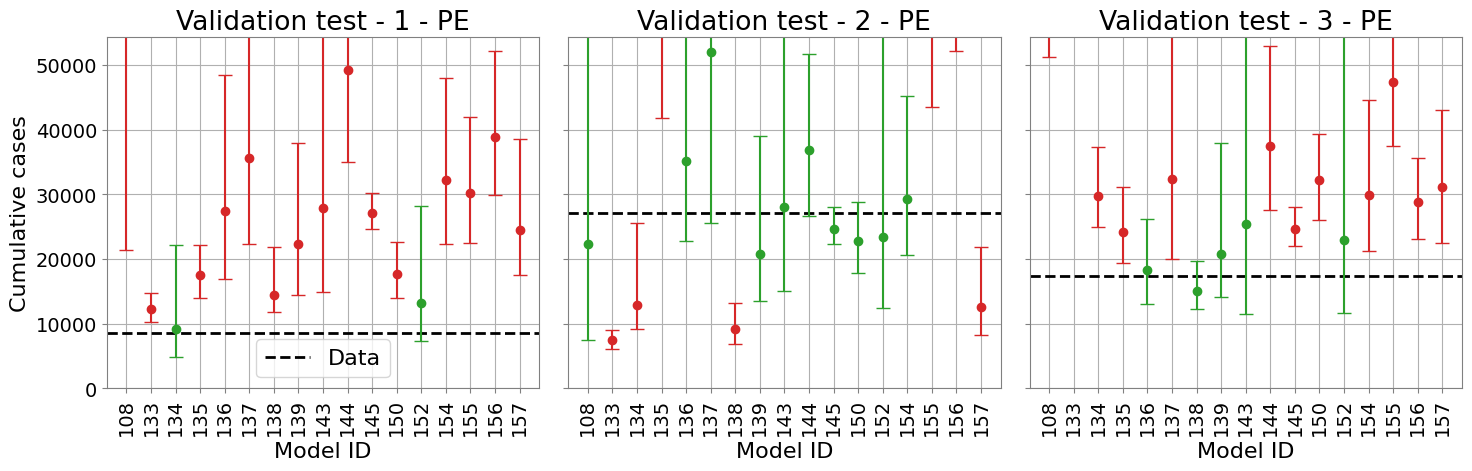

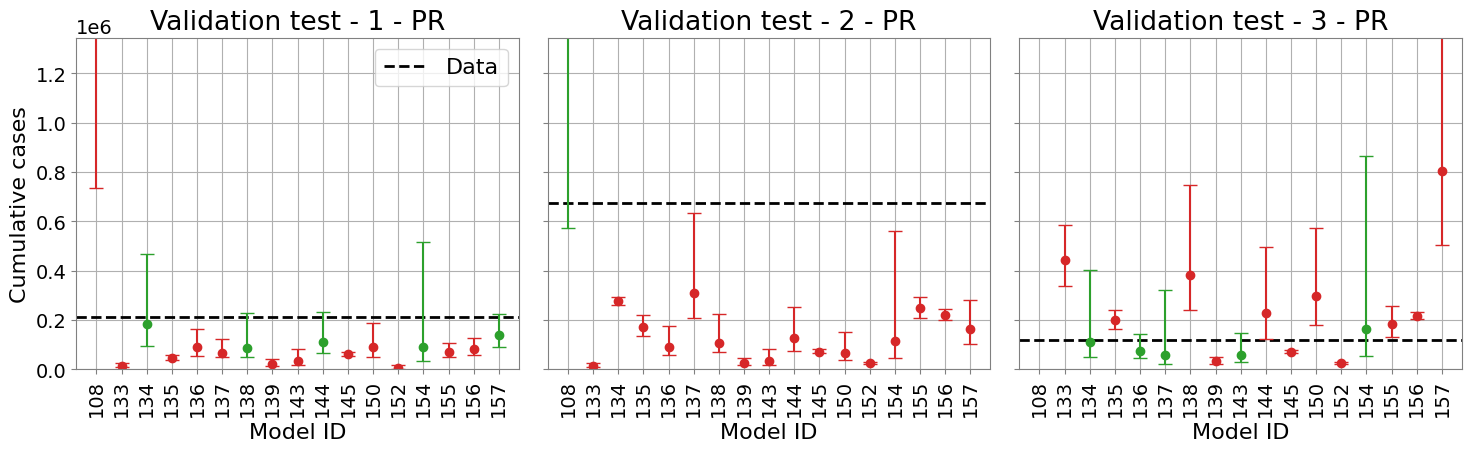

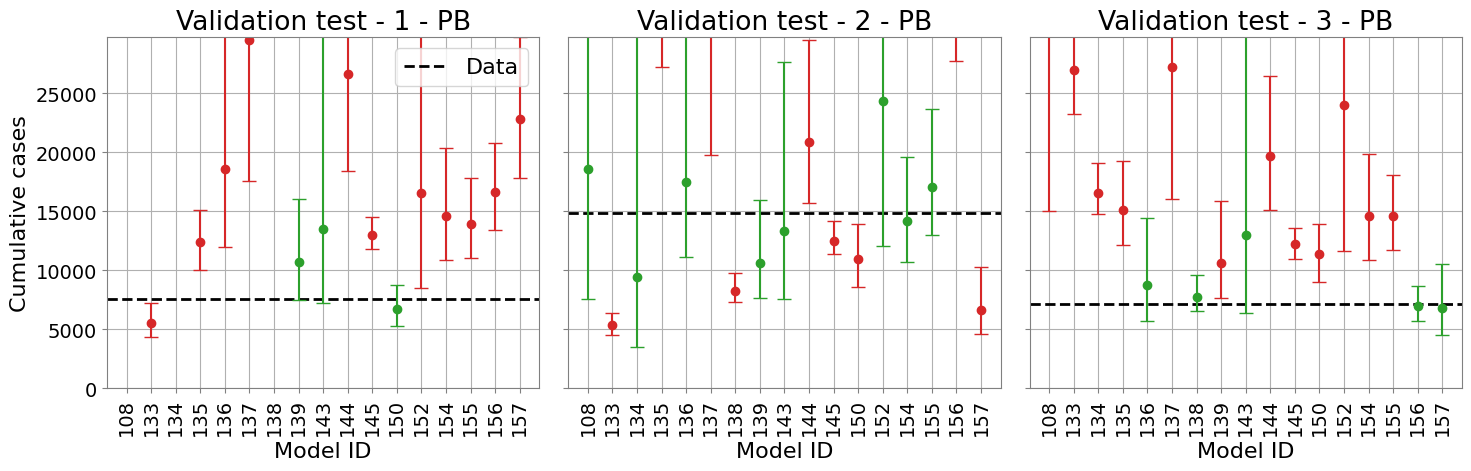

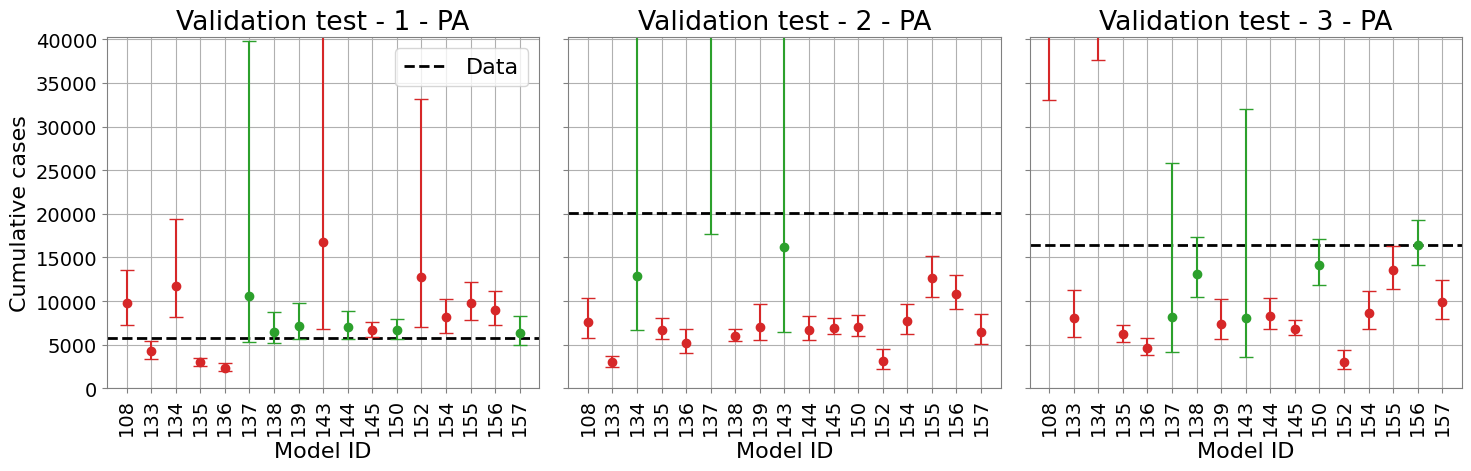

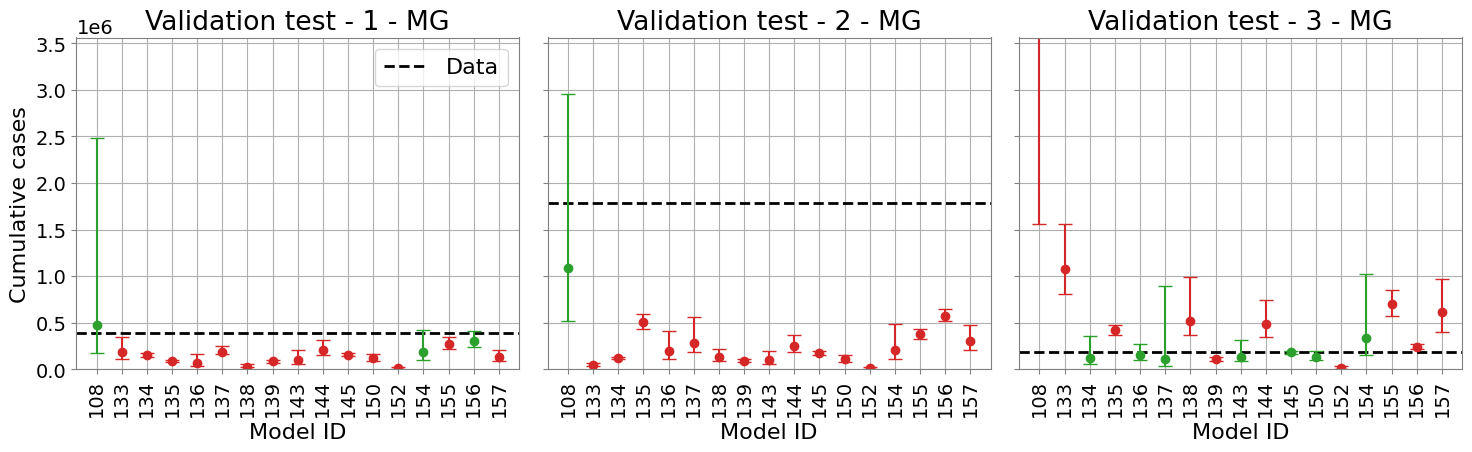

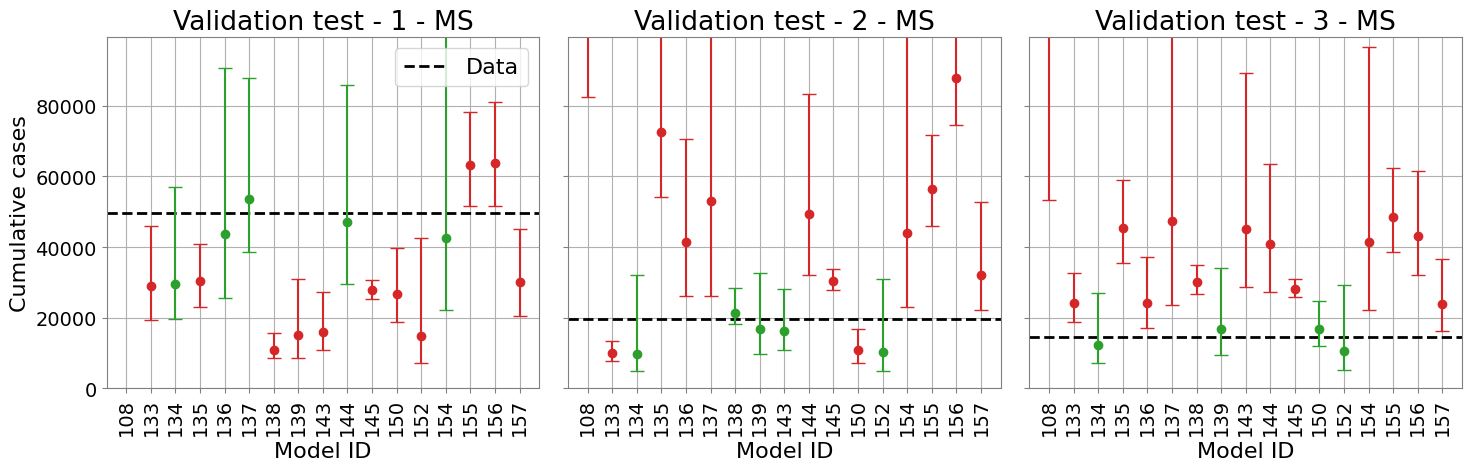

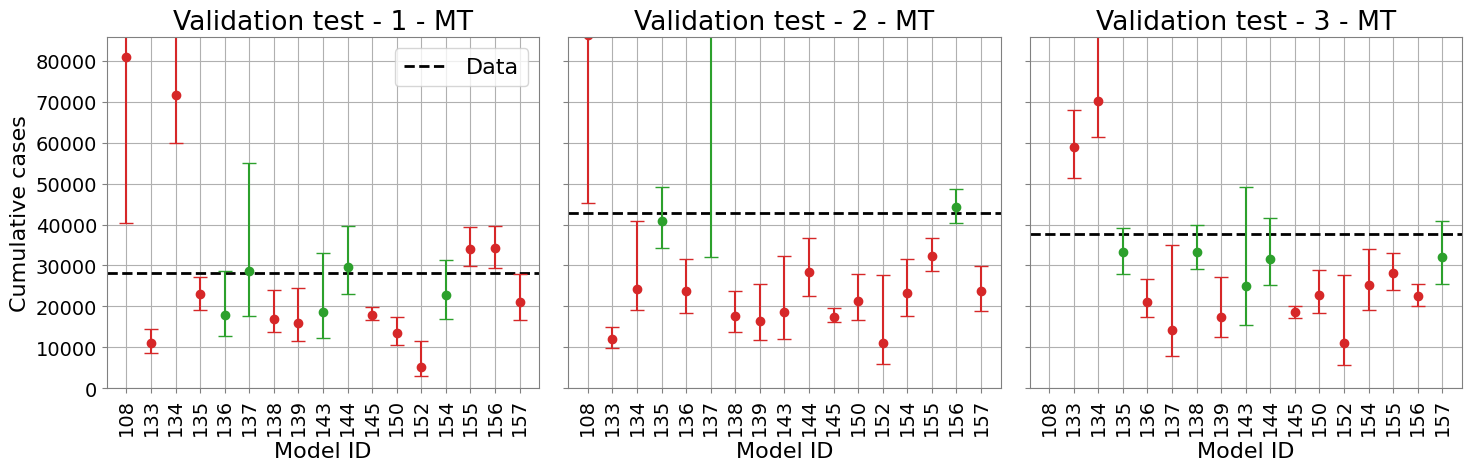

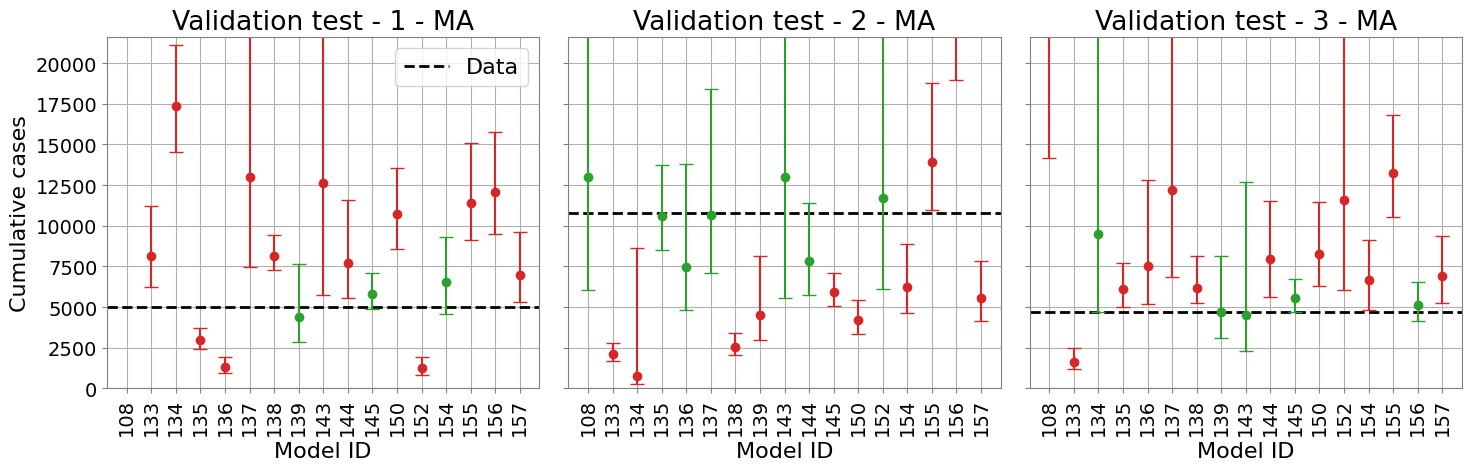

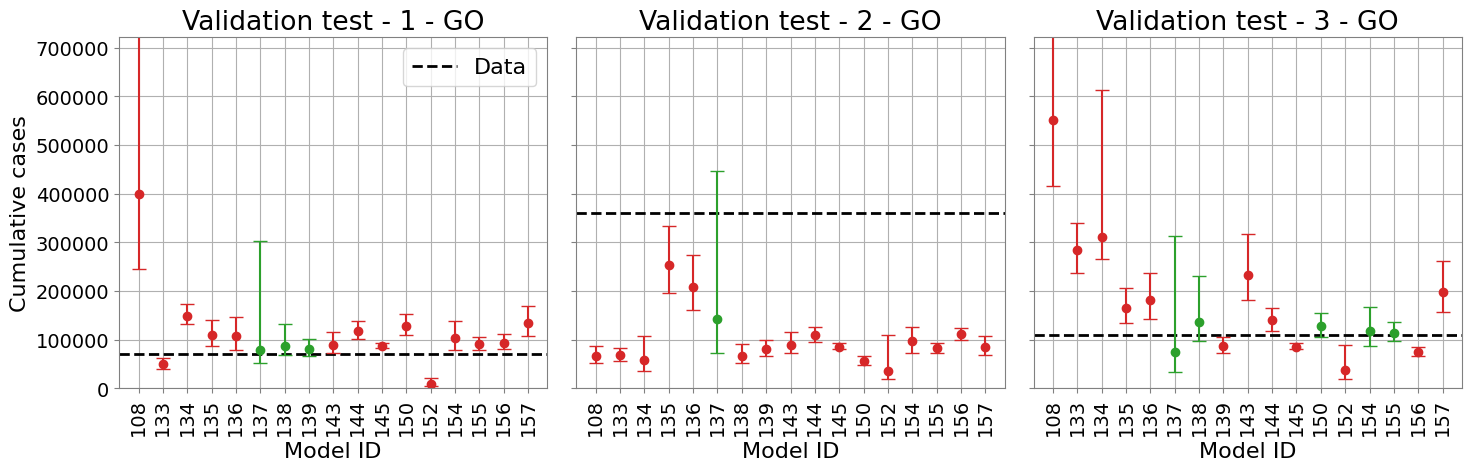

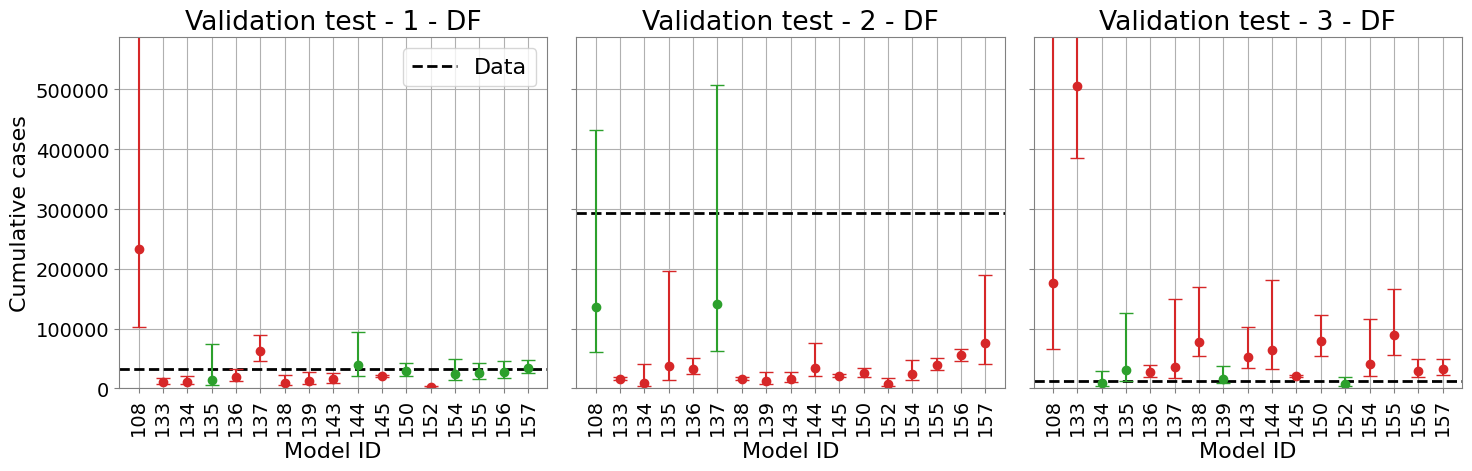

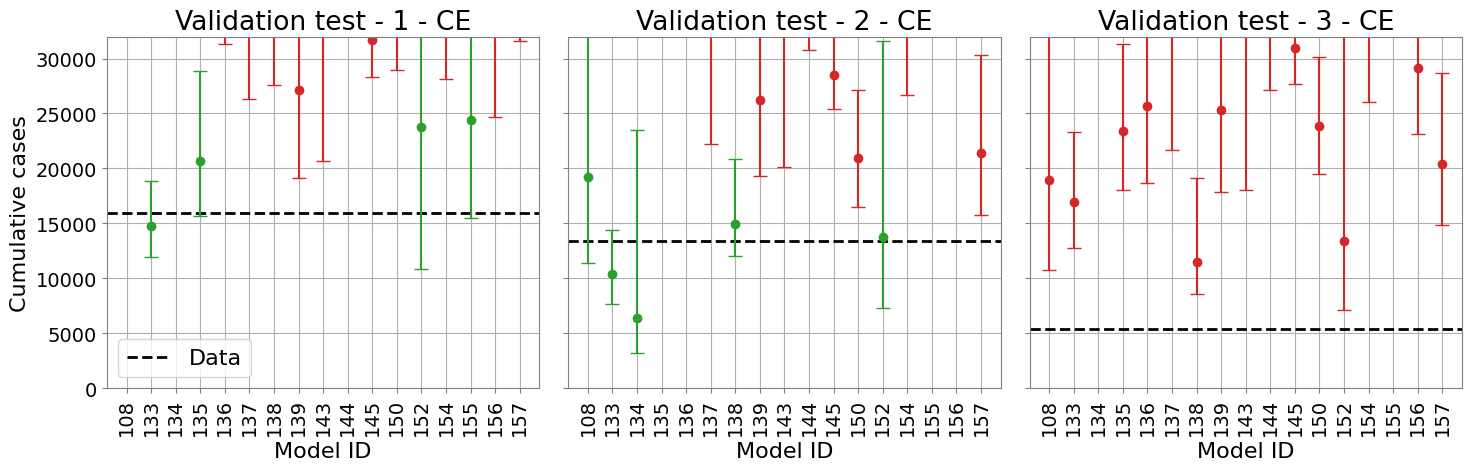

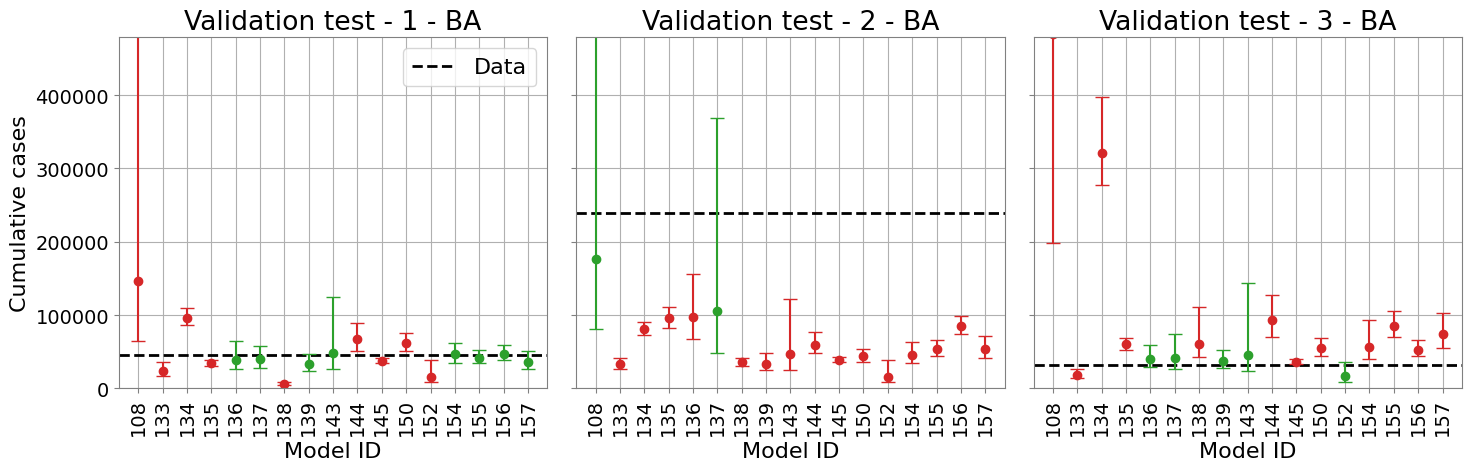

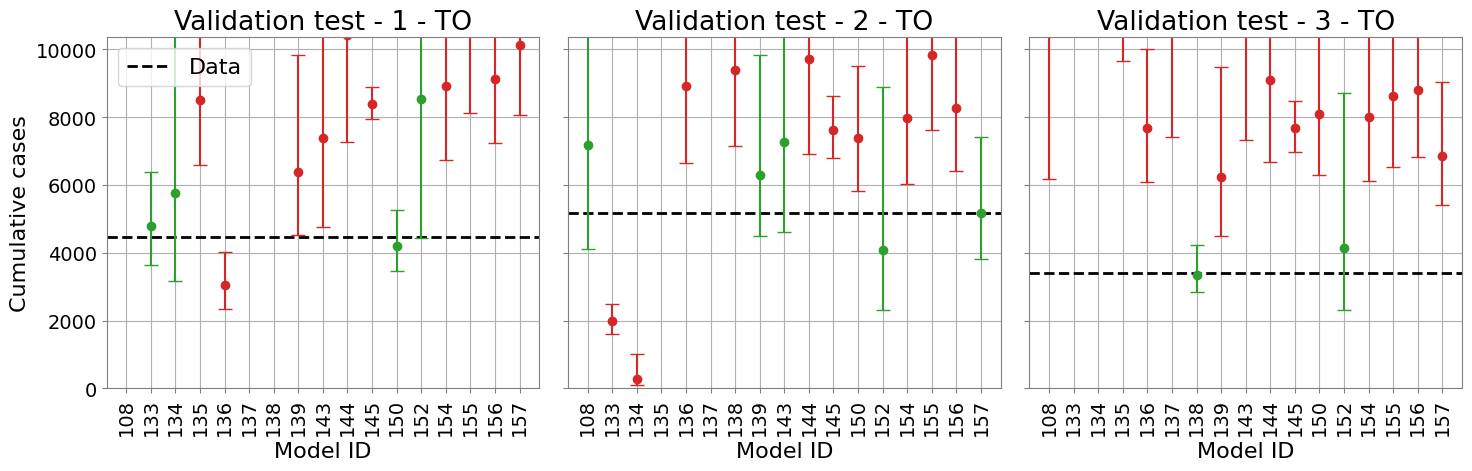

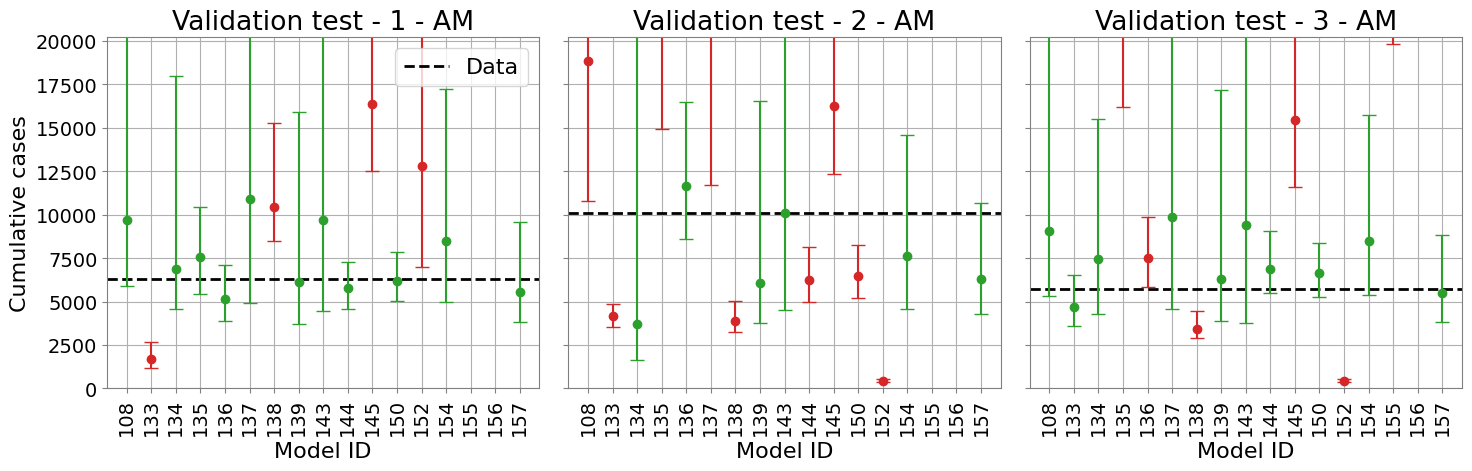

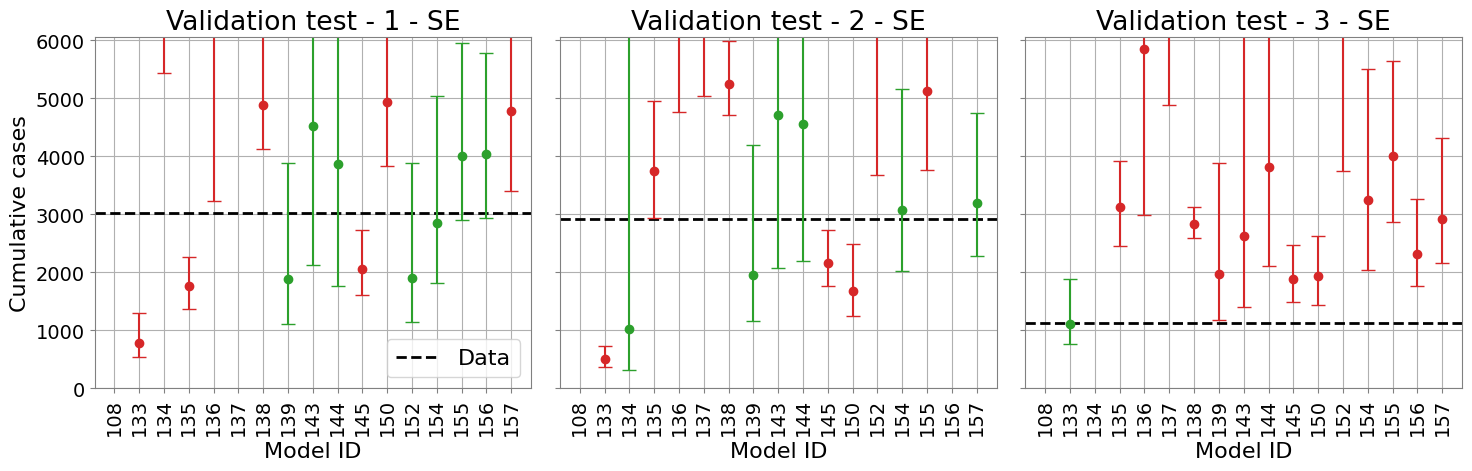

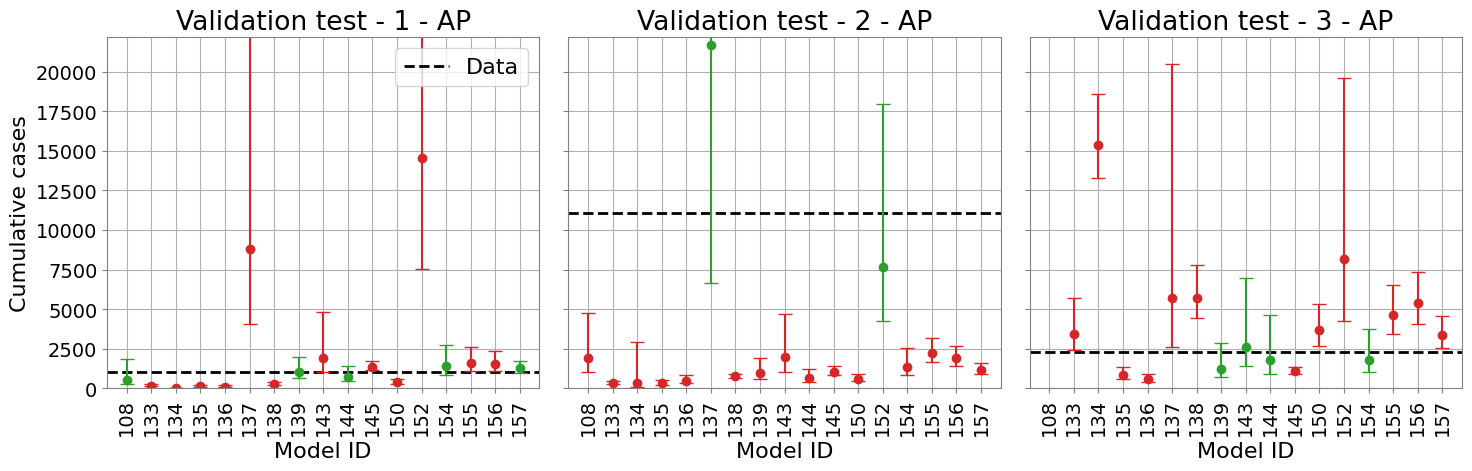

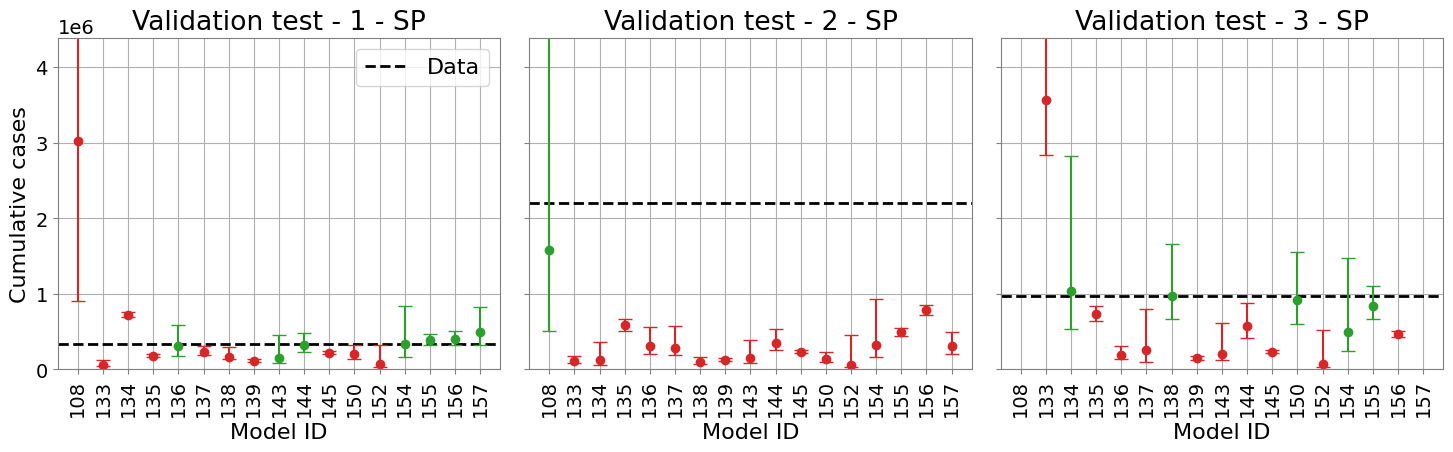

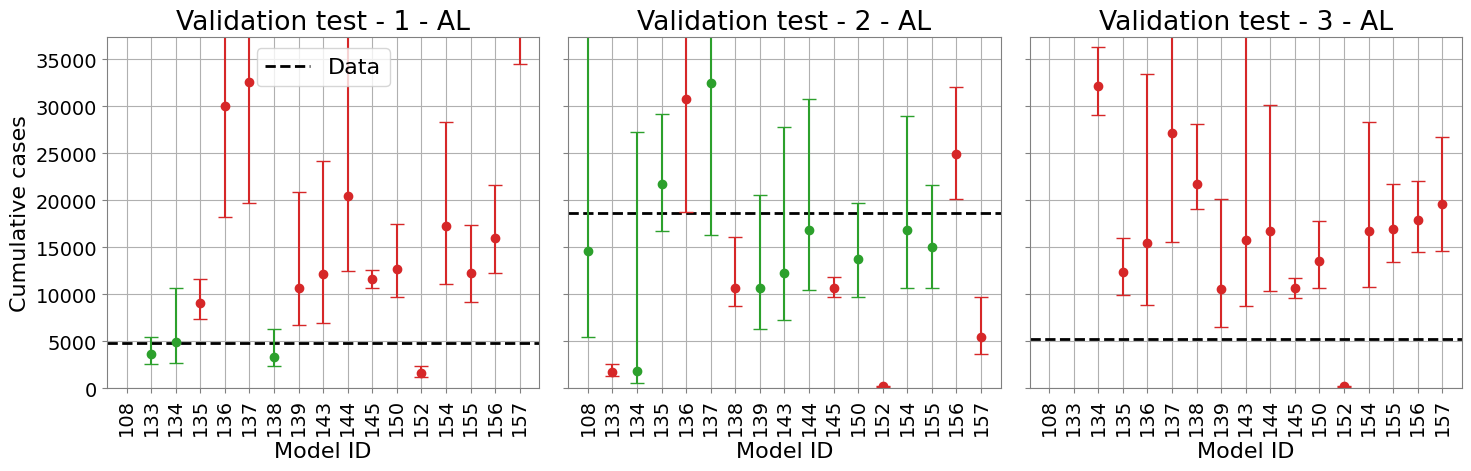

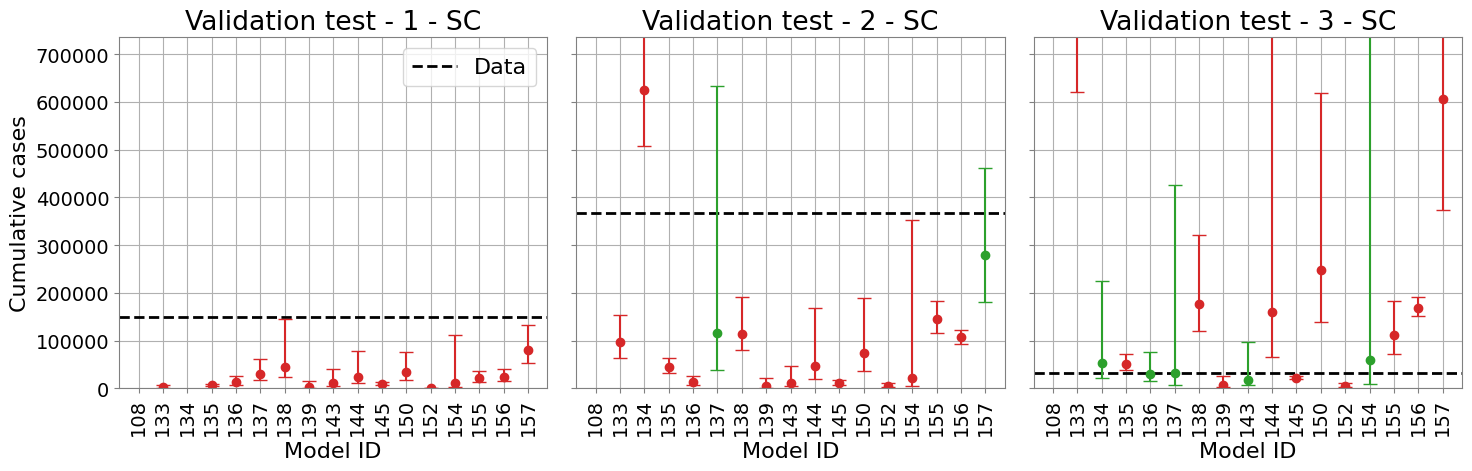

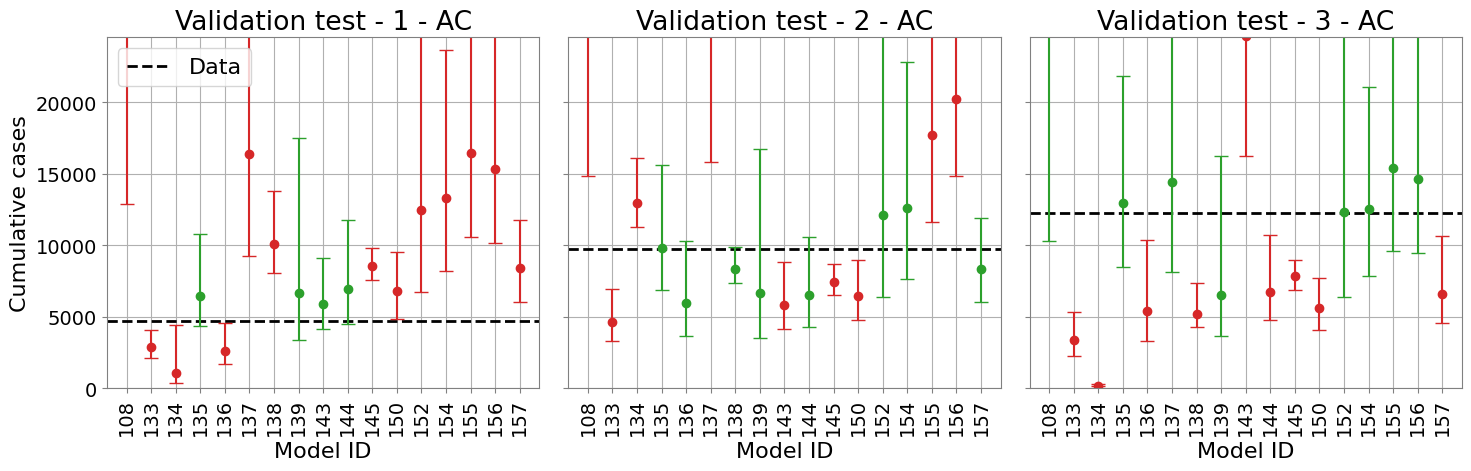

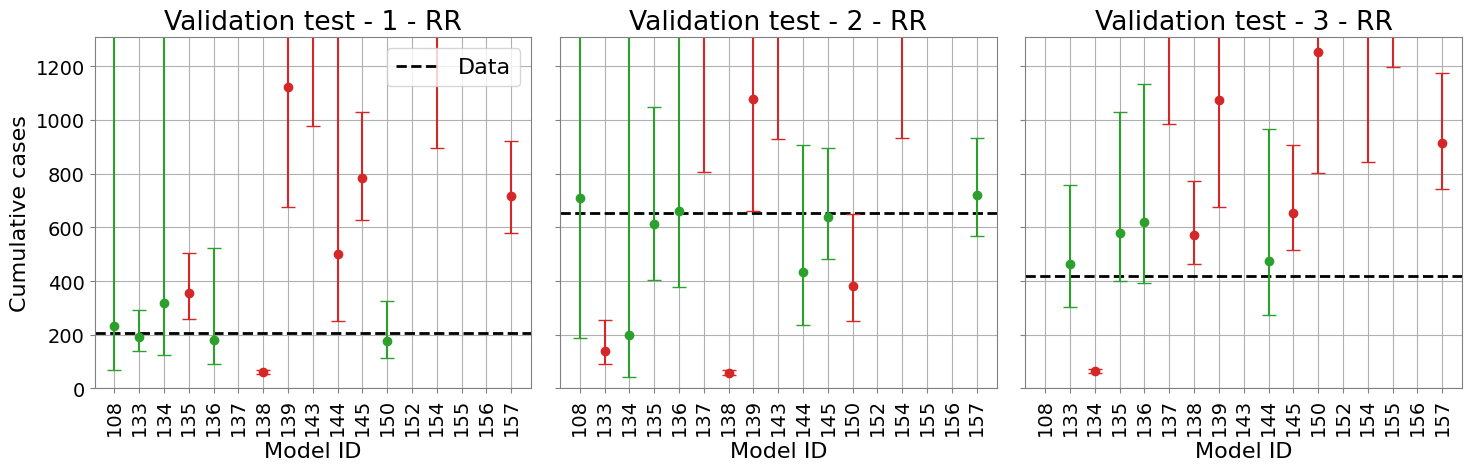

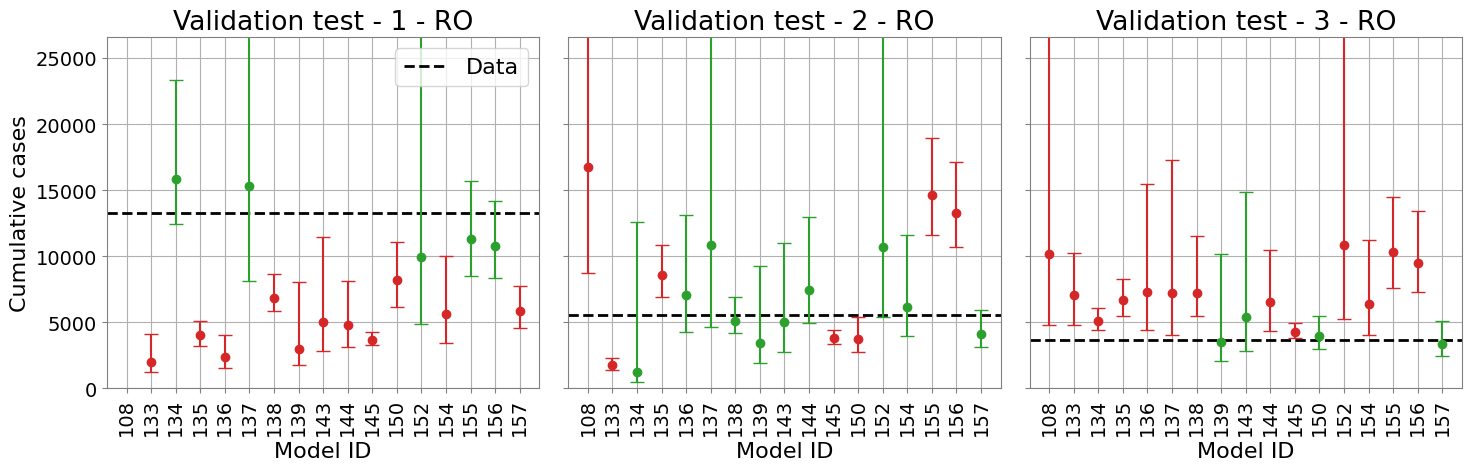

In [26]:
for state in df_cum_cases_agg.state.unique(): 
    _, ax = plt.subplots(1, 3, figsize = (15,5), sharey = True)
    
    make_plot(ax[0], df_cum_cases_agg, state= state, valid_test = 1)
    make_plot(ax[1], df_cum_cases_agg, state= state, valid_test = 2)
    make_plot(ax[2], df_cum_cases_agg, state= state, valid_test = 3)
    
    ax[1].legend().remove()
    ax[2].legend().remove()
    
    ax[1].set_ylabel('')
    ax[2].set_ylabel('')
    
    plt.tight_layout()
    
    plt.savefig(f'figures/total_cases_{state}.png', dpi = 400, bbox_inches = 'tight')
    
    plt.show()

Compute the model WIS:



In [27]:
from mosqlient.scoring import compute_wis

In [36]:
df_ = df_cum_cases_agg.copy()

df_['WIS'] = compute_wis(
                        df_[['lower_95', 'lower_90', 'lower_80', 'lower_50',
                           'pred', 'upper_50', 'upper_80', 'upper_90', 'upper_95']],
                        observed_value = df_['casos'].values)

df_.head()

,model_id,state,valid_test,lower_95,lower_90,lower_80,lower_50,pred,upper_50,upper_80,upper_90,upper_95,casos,WIS
0,108,RS,3,3.587993e+06,4.437816e+06,6.212480e+06,9.902456e+06,1.811139e+07,4.176463e+07,1.029506e+08,1.755838e+08,3.132201e+08,88884,1.482976e+07
1,133,RS,3,3.347567e+05,3.573175e+05,3.804145e+05,4.257628e+05,4.805270e+05,5.505005e+05,6.312161e+05,6.919411e+05,7.357093e+05,88884,3.159015e+05
2,134,RS,3,5.337534e+05,5.470363e+05,5.712743e+05,6.119451e+05,6.662994e+05,7.410743e+05,8.288667e+05,8.894661e+05,9.373726e+05,88884,5.072076e+05
3,135,RS,3,2.497842e+04,2.542642e+04,2.632379e+04,2.805932e+04,3.014639e+04,3.226802e+04,3.449388e+04,3.579211e+04,3.678028e+04,88884,5.516734e+04
4,136,RS,3,1.270966e+04,1.395121e+04,1.617627e+04,2.053734e+04,2.762188e+04,3.754131e+04,5.300411e+04,6.591558e+04,7.996254e+04,88884,3.599041e+04


In [37]:
df_[['model_id', 'state', 'valid_test', 'WIS']].to_csv('results/metrics_total_cases.csv', index = False)